# **Disentangled Representational Learning of Single Lead Electrocardiogram Signals using Variational Autoencoder**

This notebook evaluates the properties and accuracy of the trained VECG model in several aspects. The structure follows the three main objectives:

1. investigation of **Disentanglement**
2. evaluation of **Anomaly Detection** accuracy and explainability
3. improvements through the use of **Personalization**

The results are summarized in a corresponding article, which the authors ask to be cited when using the results of this work.

## General

This section of for imports, getting an overview of all experiments, and loading the most suitable model.

In [2]:
import sys
import os
import warnings
import logging
from absl import logging as absl_logging

# ✅ Ensure Correct TensorFlow Configuration
os.environ['TFDS_DATA_DIR'] = r"/data/newc6477/tfds_data/"
os.environ['TF_ENABLE_ONEDNN_OPTS'] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

# ✅ Ensure Correct Working Directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

print(f"📂 Project Root: {PROJECT_ROOT}")

# ✅ Ensure `src/` is in Python's Path
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

print(f"✅ Updated sys.path:\n{sys.path}")

# ✅ Suppress Warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
absl_logging.set_verbosity(absl_logging.ERROR)

# ✅ Import Modules
try:
    from src.utils.helper import Helper
    from src.evaluate.visualizations import Visualizations
    print("✅ Successfully imported `Helper` and `Visualizations`")
except ModuleNotFoundError as e:
    print(f"❌ Import Error: {e}")
    print("🔍 Check if `src/` has `__init__.py` and is in `sys.path`.")

# ✅ Import Other Required Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import glob
from neurokit2.signal import signal_smooth

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import ipywidgets as widgets
from matplotlib import pyplot as plt
import seaborn as sns



📂 Project Root: /users/newc6477/VAE/12_Lead_VECG
✅ Updated sys.path:
['/users/newc6477/Benchmark_ISIBrno/ENTER/envs/my_env/lib/python310.zip', '/users/newc6477/Benchmark_ISIBrno/ENTER/envs/my_env/lib/python3.10', '/users/newc6477/Benchmark_ISIBrno/ENTER/envs/my_env/lib/python3.10/lib-dynload', '', '/users/newc6477/Benchmark_ISIBrno/ENTER/envs/my_env/lib/python3.10/site-packages', '/users/newc6477/VAE/12_Lead_VECG', '/users/newc6477/VAE/12_Lead_VECG/src']


2025-03-05 12:08:27.671260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741176507.845819 2024078 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741176507.899398 2024078 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Successfully imported `Helper` and `Visualizations`


In [3]:
# The resolution for saving images
DPI = 300

# The source path of the experiments and models
PATH = r"/users/newc6477/VAE/12_Lead_VECG/results/run_10s"

# Some operations take some time in computation.
# Therefore, the stored intermediate results can be used to skip the respective computation.
USE_PRECOMPUTED = True

Whenever a dataset is used within this work, e.g., for loading or embedding, it needs to be declared as a dictionary. The keys are a name (array of datasets to be loaded), the split, the shuffle size, and the batch size.

In [88]:
datasets = {
    'name': ['synth:1.0.11'],
    'split': 'train',
    'shuffle_size': 1024,
    'batch_size': 1024,
}

All models and their performance indicators during training are loaded, and the mututal information gap (MIG) is calculated based on the provided dataset. The experiment(..) function returns a Pandas data frame, which is then sorted based on the MIG score to select the best fitting model.

In [89]:
import os
import sys
import os

PROJECT_DIR = os.path.abspath("src")  # Adjust if necessary
if PROJECT_DIR not in sys.path:
    sys.path.append(PROJECT_DIR)

print("✅ sys.path updated:", sys.path)


df = Helper.experiments(datasets, path=PATH)

✅ sys.path updated: ['C:\\Users\\Thomas Kaprielian\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip', 'C:\\Users\\Thomas Kaprielian\\AppData\\Local\\Programs\\Python\\Python310\\DLLs', 'C:\\Users\\Thomas Kaprielian\\AppData\\Local\\Programs\\Python\\Python310\\lib', 'C:\\Users\\Thomas Kaprielian\\AppData\\Local\\Programs\\Python\\Python310', "c:\\Users\\Thomas Kaprielian\\Documents\\Master's Thesis\\VECG\\venv", '', "c:\\Users\\Thomas Kaprielian\\Documents\\Master's Thesis\\VECG\\venv\\lib\\site-packages", "c:\\Users\\Thomas Kaprielian\\Documents\\Master's Thesis\\VECG\\venv\\lib\\site-packages\\win32", "c:\\Users\\Thomas Kaprielian\\Documents\\Master's Thesis\\VECG\\venv\\lib\\site-packages\\win32\\lib", "c:\\Users\\Thomas Kaprielian\\Documents\\Master's Thesis\\VECG\\venv\\lib\\site-packages\\Pythonwin", "c:\\Users\\Thomas Kaprielian\\Documents\\Master's Thesis\\VECG", "c:\\Users\\Thomas Kaprielian\\Documents\\Master's Thesis\\VECG\\src", "c:\\Users\\Thomas Kaprielian\\Doc

FileNotFoundError: [Errno 2] No such file or directory: "C:\\Users\\Thomas Kaprielian\\Documents\\Master's Thesis\\VECG\\results\\run_10s\\I\\params.json"

In [16]:
df.sort_values(by=['MIG', 'latent_dim', 'alpha', 'beta', 'gamma']).tail()

,alpha,beta,gamma,loss,recon,mi,tc,dw_kl,time,latent_dim,epoch,total,MIG
44,0.05,0.20,0.05,0.138120,0.103311,-0.011708,-0.002746,0.718868,2025-02-23 19:48:39,24,3,0.807726,0.088992
45,0.01,0.04,0.01,0.083023,0.083232,0.000283,-0.005103,-0.000721,2025-02-23 19:50:18,8,97,0.077691,0.090525
7,0.05,0.20,0.05,0.106408,0.101170,-0.002923,-0.002937,0.119418,2025-02-23 19:39:33,8,3,0.214729,0.094426
30,0.05,0.20,0.05,0.111902,0.101677,-0.000607,-0.004786,0.224234,2025-02-23 19:45:05,8,3,0.320518,0.095879
9,0.20,0.80,0.20,0.121458,0.100817,-0.000244,-0.003427,0.117156,2025-02-23 19:39:43,8,3,0.214302,0.114445


The suggested model is loaded based on the sorting. However, other models can also be selected in the drop-down menu in order to evaluate them.

In [17]:
val = Helper.select_path(PATH)

In [18]:
val

Dropdown(description='Base path:', options=("C:\\Users\\Thomas Kaprielian\\Documents\\Master's Thesis\\VECG\\r…

In [ ]:
#path_base = val.value + '/'
path_base = os.path.join(PATH,'2025-02-23_19-37-36/')
path_model = path_base + 'model_best.keras'
model = tf.keras.models.load_model(path_model)

## 1. Disentanglement

The property of disentanglement is evaluated on the SYNECG, Medalcare, and CU-SPH (zheng) dataset. Therefore, we need the respective embeddings.

In [20]:
datasets = {
    'name': ['synth:1.0.11'],
    'split': 'train',
    'shuffle_size': 1024,
    'batch_size': 1024,
}
embeddings, ld = Helper.get_embeddings(model, datasets)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


The axis-feature relationship is calculated using the coefficient of determination ($R^2$) from a one-dimensional linear regression. A higher predictability (score) is assumed to be a higher association of a dimension with a feature. In addition, a large gap between the first score and the associated feature to the second highest recognized feature indicates a higher degree of disentanglement, as it indicates that only one feature is encoded along the axis. Both a tabular and a visual representation are shown.

In [21]:
struct = Helper.feature_axis_mapping(embeddings, ld)
interpretation = Helper.readable_axis_mapping(struct)

In [22]:
Visualizations.print_axis_interpretation(interpretation)

,Dimension,Feature_0,Feature_1,Feature_2,Feature_3
0,0,p_width: 0.23156,s_width: 0.16742,q_width: 0.10941,t_height: 0.048
0,1,r_width: 0.24488,s_width: 0.06881,p_width: 0.06478,p_height: 0.04448
0,2,p_width: 0.23398,s_width: 0.13557,r_width: 0.12114,q_width: 0.03989
0,3,q_width: 0.20169,s_width: 0.12628,p_width: 0.0462,r_height: 0.03381
0,4,r_width: 0.11064,q_width: 0.07454,p_width: 0.06898,t_height: 0.0662
0,5,r_width: 0.26104,p_width: 0.24013,s_width: 0.08399,t_height: 0.05349
0,6,q_width: 0.14433,r_width: 0.12247,s_width: 0.06446,p_width: 0.04255
0,7,s_width: 0.29979,p_width: 0.2355,r_height: 0.04412,q_width: 0.0406


../analysis/media


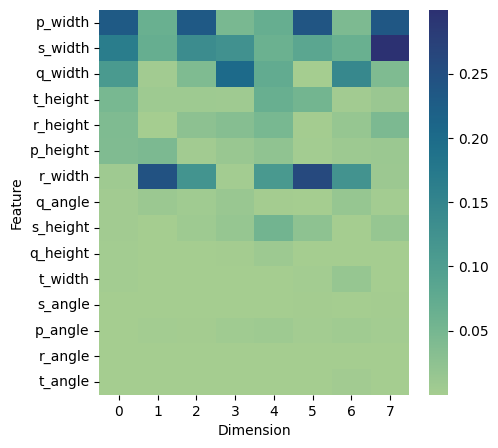

In [23]:
Visualizations.plot_axis_relation(interpretation, ld, save_path='../analysis/media/axis_feature_corrplot_axis_relationelation.png', dpi=DPI)

We want to investigate how the features with the highest axis relation are distributed and whether they have a orthogonal structure, which would indicate disentanglement.

In [24]:
plt.rcParams['font.size'] = 14

<Figure size 346.457x259.843 with 0 Axes>

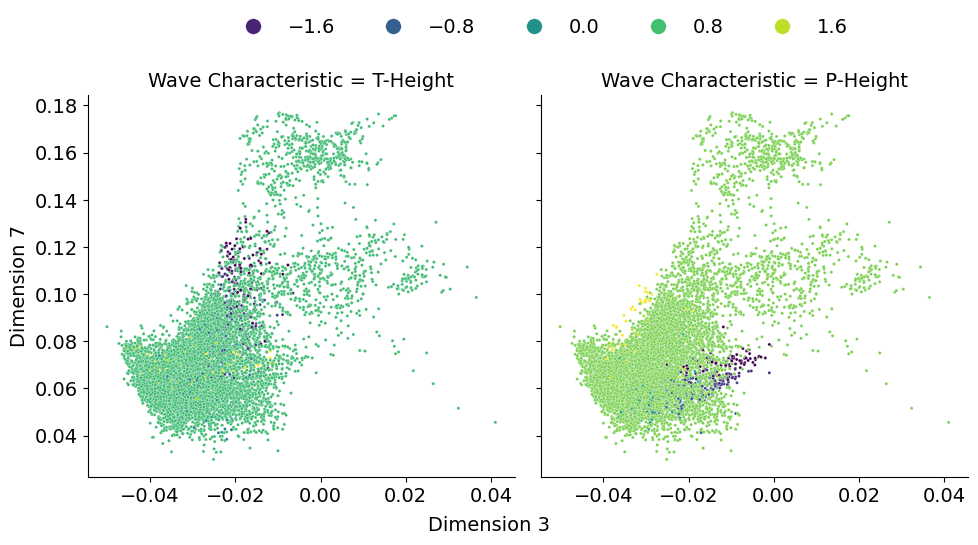

In [25]:
Visualizations.plot_scatter(embeddings[0], 3, 7, 't_height', 'p_height', 'T-Height', 'P-Height', DPI, path_save='../analysis/media/embedding_synthetic.png')

To evaluate the effects of switching certain dimensions in the embedding, reconstruction plots are created. The reconstructions are created based on VAE priority (i.e. $\vec{0}$) and only one dimension is changed in the range of -15 to 15. The visual inspection shows whether only one particular feature is affected or several. For illustration purposes, the title of the diagram is set to the characteristics and the corresponding $R^2$ values of the previous calculation.

In [27]:
# Adaptation of the interpretations (based on the table above) to make them look more trendy and accessible in the final presentation.
# We also add the expert assessment of the changes seen in the ECG.
interpretation = {
    "Dim 0": {
        "Features": ["P-wave height"],
        "Scores": [0.33736],
        "Rater": ["Mode collapse"],
    },
    "Dim 1": {
        "Features": ["P-wave height"],
        "Scores": [0.47015],
        "Rater": ["P-wave height", "PQ interval"],
    },
    "Dim 2": {
        "Features": ["R-peak width"],
        "Scores": [0.21962],
        "Rater": ["Mode collapse"],
    },
    "Dim 3": {
        "Features": ["P-wave height"],
        "Scores": [0.82414],
        "Rater": ["P-wave height", "Q-wave width"],
    },
    "Dim 4": {
        "Features": ["S-wave width"],
        "Scores": [0.29907],
        "Rater": ["Baseline", "S-wave width"],
    },
    "Dim 5": {
        "Features": ["P-wave height and width"],
        "Scores": [0.49542],
        "Rater": ["Redundant to Dimension 7"],
    },
    "Dim 6": {
        "Features": ["R-peak width"],
        "Scores": [0.39818],
        "Rater": ["QRS-width", "P-wave height"],
    },
    "Dim 7": {
        "Features": ["T-wave height"],
        "Scores": [0.89084],
        "Rater": ["T-wave height"],
    },
    "Dim 8": {
        "Features": ["P-wave height", "", ""],
        "Scores": [0.5763],
        "Rater": ["Unclear"],
    },
    "Dim 9": {
        "Features": ["T-wave height", "", ""],
        "Scores": [0.26483],
        "Rater": ["P-wave height", "Q-wave width", "ST-segment"],
    },
    "Dim 10": {
        "Features": ["QT interval", "", ""],
        "Scores": [0.13607],
        "Rater": ["ST segment", "QT-interval"],
    },
    "Dim 11": {
        "Features": ["P-wave height"],
        "Scores": [0.41909],
        "Rater": ["T-wave height", "QT-interval"],
    }
}

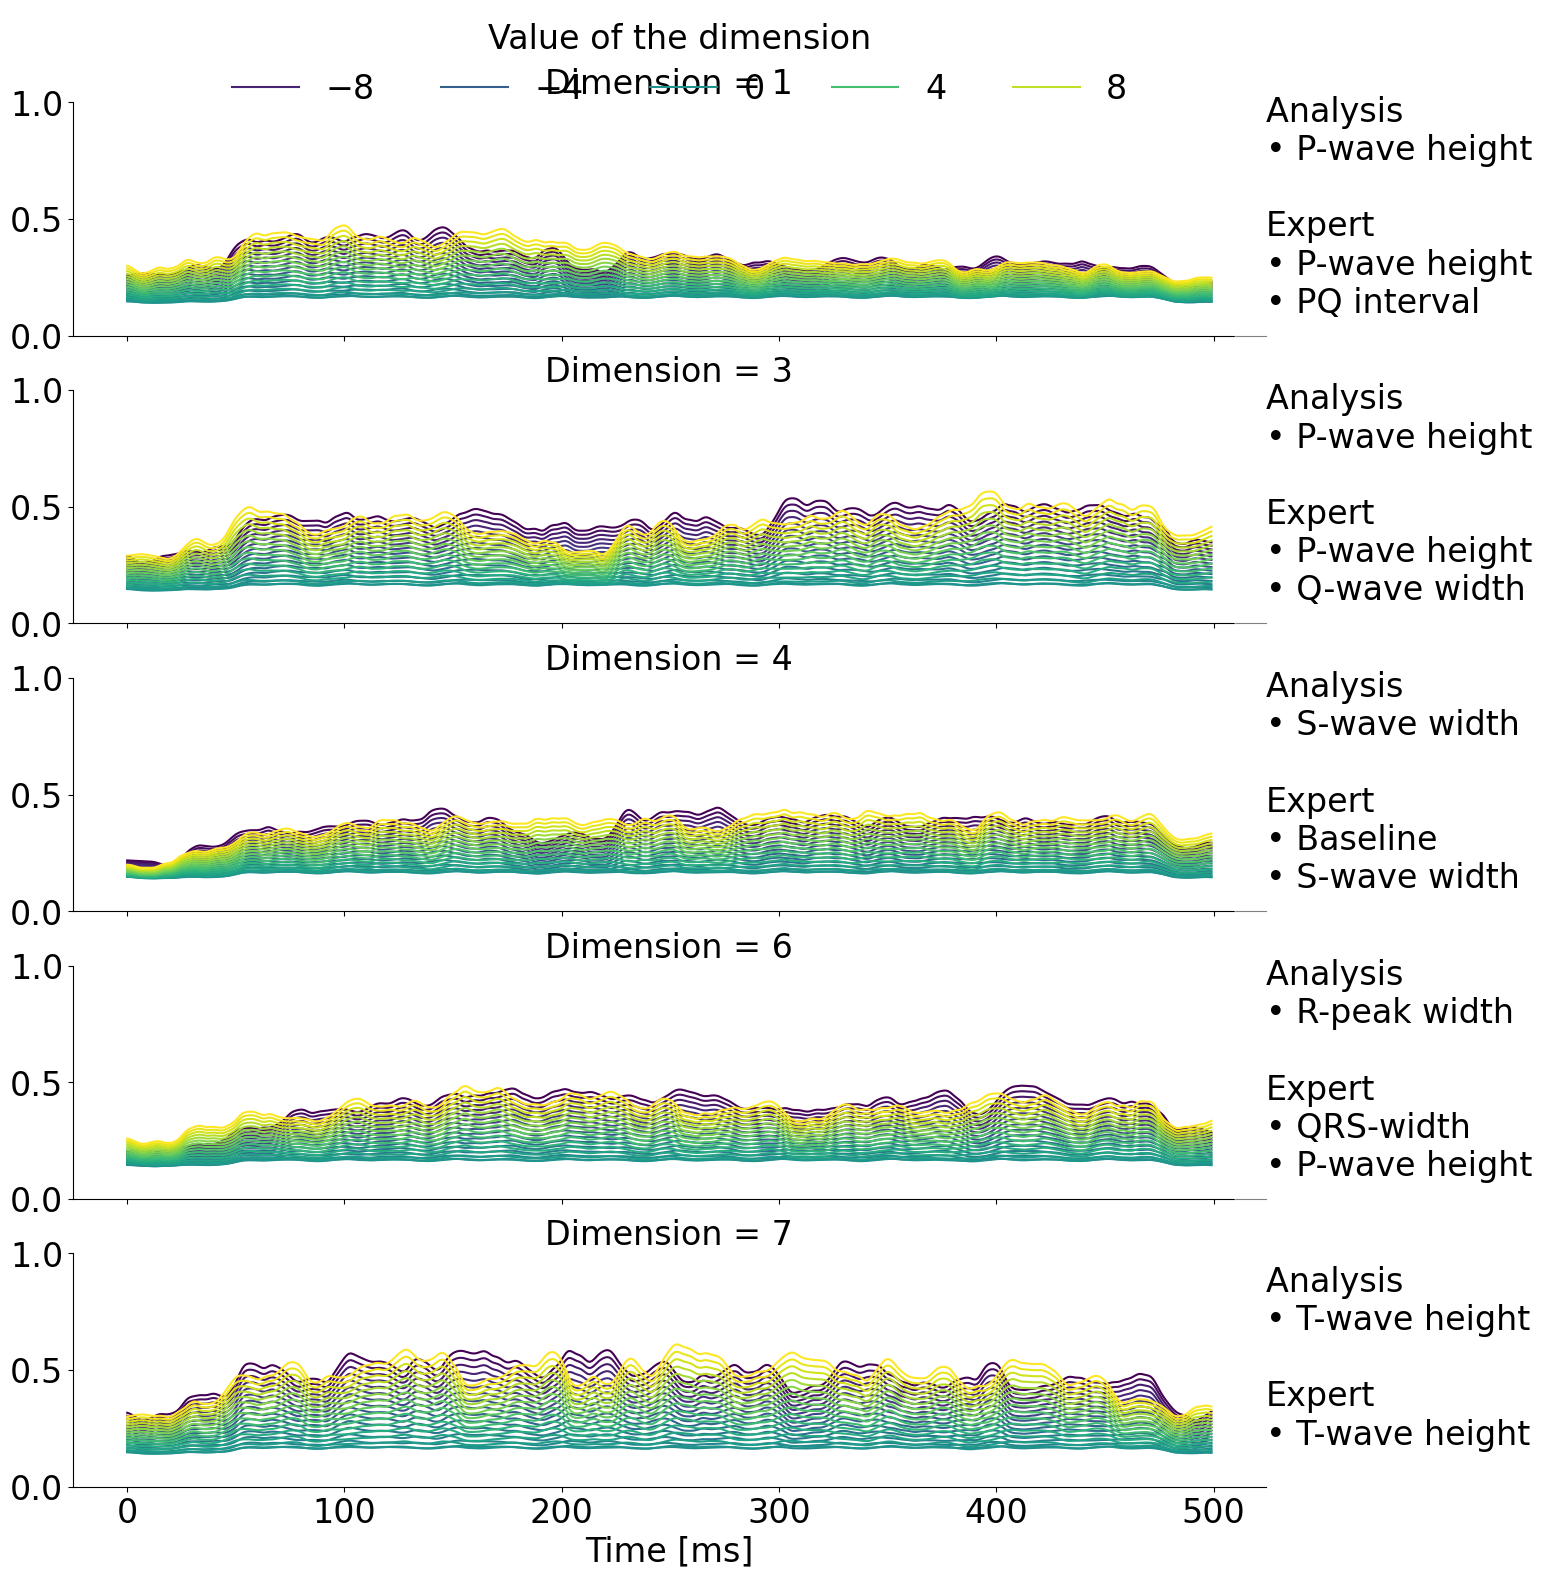

In [29]:
plt.rcParams['font.size'] = 24
x_values = list(np.linspace(-10.0, 10.0, 30))
path = '../analysis/media/'
dimensions=[1, 3, 4, 6, 7, 9, 10, 11]

Visualizations.plot_with_facetgrid(ld, x_values, path, model, interpretation, DPI, dimensions)

In [30]:
widgets.interact(Visualizations.reconstruct, dim=range(0, ld), x=(-100.0, 100.0, 0.5), model=[model], ld=[ld])

interactive(children=(Dropdown(description='dim', options=(0, 1, 2, 3, 4, 5, 6, 7), value=0), FloatSlider(valu…

<function src.evaluate.visualizations.Visualizations.reconstruct(dim, x, model, ld)>

# 2. Anomaly Detection

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## physionet

### Data Preparation

The consecutive steps are:

1. Loading the physionet train, validation, and test data set
2. Embedding the data sets
3. Excluding the non-relevant pathologies, i.e., LAE, ICB, FAC
4. Preparing the matrix and their associated binary and multiclass labels

In [4]:
import os
import tensorflow as tf

BASE = PATH  # Set the correct path to your BASE directory
models = []

# Get all lead folders in BASE directory
folders = [f for f in os.listdir(BASE) if os.path.isdir(os.path.join(BASE, f))]

for lead in folders:
    lead_path = os.path.join(BASE, lead)
    
    # Find the first subfolder within the current lead folder
    subfolders = [sf for sf in os.listdir(lead_path) if os.path.isdir(os.path.join(lead_path, sf))]
    
    if subfolders:
        first_subfolder = subfolders[0]  # Assuming we want the first available subfolder
        model_path = os.path.join(lead_path, first_subfolder, 'model_best.keras')
        
        if os.path.exists(model_path):
            print(f"Loading model from: {model_path}")
            model = tf.keras.models.load_model(model_path)
            models.append(model)
        else:
            print(f"Warning: Model file not found at {model_path}")
    else:
        print(f"Warning: No subfolders found in {lead_path}")

print(f"Loaded {len(models)} models successfully.")


Loading model from: /users/newc6477/VAE/12_Lead_VECG/results/run_10s/I/2025-03-04_23-00-01/model_best.keras


2025-03-05 12:09:26.758851: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Loading model from: /users/newc6477/VAE/12_Lead_VECG/results/run_10s/II/2025-03-04_23-05-09/model_best.keras
Loading model from: /users/newc6477/VAE/12_Lead_VECG/results/run_10s/III/2025-03-04_23-10-17/model_best.keras
Loading model from: /users/newc6477/VAE/12_Lead_VECG/results/run_10s/aVR/2025-03-04_23-15-44/model_best.keras
Loading model from: /users/newc6477/VAE/12_Lead_VECG/results/run_10s/aVL/2025-03-04_23-21-23/model_best.keras
Loading model from: /users/newc6477/VAE/12_Lead_VECG/results/run_10s/aVF/2025-03-04_23-26-38/model_best.keras
Loading model from: /users/newc6477/VAE/12_Lead_VECG/results/run_10s/V1/2025-03-04_23-31-51/model_best.keras
Loading model from: /users/newc6477/VAE/12_Lead_VECG/results/run_10s/V2/2025-03-04_23-37-19/model_best.keras
Loading model from: /users/newc6477/VAE/12_Lead_VECG/results/run_10s/V3/2025-03-04_23-42-39/model_best.keras
Loading model from: /users/newc6477/VAE/12_Lead_VECG/results/run_10s/V4/2025-03-04_23-47-55/model_best.keras
Loading model f

In [6]:
dataset_physionet_train = {'name': ['physionet'], 'split': 'train', 'shuffle_size': 1024, 'batch_size': 1024}
dataset_physionet_validation = {'name': ['physionet'], 'split': 'validation', 'shuffle_size': 1024, 'batch_size': 1024}
dataset_physionet_test = {'name': ['physionet'], 'split': 'test', 'shuffle_size': 1024, 'batch_size': 1024}

In [7]:
df_physionet_train, ld = Helper.get_embeddings(models, dataset_physionet_train)
#df_physionet_validation, _ = Helper.get_embeddings(model, dataset_physionet_validation)
df_physionet_test, _ = Helper.get_embeddings(models, dataset_physionet_test)

df_physionet_train = df_physionet_train[0]
#df_physionet_validation = df_physionet_validation[0]
df_physionet_test = df_physionet_test[0]
print(type(df_physionet_train))


Processing lead I...
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Processing lead II...
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Processing lead III...
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Processing lead aVR...
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Processing lead aVL...
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Processing lead aVF...
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Processing lead V1...
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Processing lead V2...
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Processing lead V3...
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Processing lead V4...
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Processing lead V5...
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Processing lead V6...
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
✅ Embeddings successfully merged!
Final shape: (46539, 144)
First sample's feature vector:
 [ 0.01019364  0.00766045  0.0098476   0.03527785  0.01367112  0.00037966
 -0.0072023  -0.00043073 -0.01349696 -0.02270985  0.04102907 -0.00136364
  0.01108218  0

In [8]:
import numpy as np

def one_hot_to_labels(y_onehot, class_labels):
    """
    Converts a one-hot encoded label matrix to human-readable class labels.
    
    Args:
        y_onehot (np.array): One-hot encoded labels (shape: num_samples × num_classes).
        class_labels (list): List of class names corresponding to each index in the one-hot encoding.

    Returns:
        np.array: Array of string labels, where multiple diagnoses are joined by "_".
    """
    y_labels = []
    for row in y_onehot:
        indices = np.where(row == 1)[0]  # Find indices of '1's in the row
        if len(indices) == 0:
            label = 0  # Assign to a new class
        else:
            label = "".join(class_labels[indices])  # Join multiple labels if multi-class
            print(label)
        y_labels.append(int(label))

    return np.array(y_labels)


In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Prepare feature matrix and labels
X_train = df_physionet_train.iloc[:, :96].values  
X_test = df_physionet_test.iloc[:, :96].values  
y_train = np.array(df_physionet_train['diagnostic'].tolist(), dtype=int)  
y_test = np.array(df_physionet_test['diagnostic'].tolist(), dtype=int)  

# Define KNN model
knn = KNeighborsClassifier()

# Wrap it inside MultiOutputClassifier
multi_label_knn = MultiOutputClassifier(knn, n_jobs=-1)

# Define Grid Search parameters for 'k'
param_grid = {
    "estimator__n_neighbors": [3, 5, 7, 9, 11]  # Testing different values of k
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    multi_label_knn, param_grid, scoring="accuracy", cv=5, n_jobs=-1
)

# Perform the Grid Search
print("🔍 Performing Grid Search...")
grid_search.fit(X_train, y_train)

# Best hyperparameter
print("✅ Best k found:", grid_search.best_params_)

# Use the best model
best_knn = grid_search.best_estimator_

# Predict using the best model
y_pred = best_knn.predict(X_test)



🔍 Performing Grid Search...


In [9]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Calculate accuracy for each label separately
accuracy_per_label = (y_pred == y_test).mean(axis=0)

# Calculate overall accuracy (percentage of completely correct multi-label predictions)
overall_accuracy = accuracy_score(y_test, y_pred)

# Compute F1-score (macro & micro average)
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_micro = f1_score(y_test, y_pred, average="micro")

# Generate classification report
class_report = classification_report(y_test, y_pred, target_names=[str(i) for i in range(y_test.shape[1])])

# Print evaluation metrics
print("✅ Overall Accuracy:", overall_accuracy)
print("✅ F1 Score (Macro):", f1_macro)
print("✅ F1 Score (Micro):", f1_micro)
print("✅ Classification Report:\n", class_report)

✅ Overall Accuracy: 0.23400158568354287
✅ F1 Score (Macro): 0.1533818131335102
✅ F1 Score (Micro): 0.2857704016498085
✅ Classification Report:
               precision    recall  f1-score   support

           0       0.11      0.05      0.07       471
           1       0.27      0.07      0.11       781
           2       0.00      0.00      0.00        54
           3       0.00      0.00      0.00        20
           4       0.61      0.36      0.45       100
           5       0.58      0.52      0.55       572
           6       0.11      0.05      0.07       364
           7       0.13      0.05      0.08       222
           8       0.34      0.31      0.33       683
           9       0.22      0.30      0.25       174
          10       0.00      0.00      0.00        42
          11       0.17      0.03      0.05       166
          12       0.03      0.01      0.02       166
          13       0.15      0.05      0.07       214
          14       0.43      0.50      0.46  

In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

print(type(df_physionet_train))
print(list(df_physionet_train.columns.values))
# Load your DataFrame (assuming it's named df)
X_train = df_physionet_train.iloc[:, :96].values  # Extract feature matrix (num_samples, 96)
X_test = df_physionet_test.iloc[:, :96].values
y_train = df_physionet_train['diagnostic'].values  # Extract one-hot encoded labels
y_test = df_physionet_test['diagnostic'].values
# Convert one-hot encoded labels to unique string labels
class_labels = np.array([
        '164889003', '164890007', '6374002', '426627000', '733534002',
        '713427006', '270492004', '713426002', '39732003', '445118002',
        '164947007', '251146004', '111975006', '698252002', '426783006',
        '284470004', '10370003', '365413008', '427172004', '164917005',
        '47665007', '427393009', '426177001', '427084000', '164934002',
        '59931005'
    ]) 
# Convert one-hot encoding to class labels

# Example usage:
y_train_labels = one_hot_to_labels(y_train, class_labels)

# Convert list to NumPy array
y_test_labels = one_hot_to_labels(y_test,class_labels)


# Print sample outputs
print("✅ Converted One-Hot Labels to Class Labels:")

<class 'pandas.core.frame.DataFrame'>
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 'lead', 'gender', 'subject', 'nsamp', 'age', 'frequency', 'diagnostic']
426783006
426783006
426783006
39732003426783006
426783006426177001
426783006
426783006
426783006426177001
39732003426783006
426783006
39732003426783006
39732003426783006
39732003426783006
39732003426783006
426783006
426783006
426783006426177001
426783006
426783006
426783006
2511

In [21]:
print(y_train_labels)
print(type(y_train_labels))  # Should be <class 'numpy.ndarray'>
print(y_train_labels.shape)  # Expected: (num_samples,)

# Print an example row to check its format
print("First label sample:", y_train_labels[0])
# Flatten y_train_labels if needed
if isinstance(y_train_labels[0], (list, np.ndarray)):  
    y_train_labels = np.array(["_".join(map(str, labels)) if len(labels) > 0 else "No_Diagnosis" for labels in y_train_labels])

print("✅ Fixed Label Shape:", y_train_labels.shape)  # Should be (num_samples,)
print("✅ First Label Example:", y_train_labels[0])  # Should be a single string



[0 0 0 ... 0 0 0]
<class 'numpy.ndarray'>
(4091,)
First label sample: 0
✅ Fixed Label Shape: (4091,)
✅ First Label Example: 0


### Multiclass

For the multi-class prediction, i.e. the separation of the classes "sinus", "rbbb", "lbbb" and "avblock", we used the k-nearest neighbor classification. The hyperparameter $k$ was determined using the Medalcare validation dataset as a cross-validation set. The best result $k$ was then used to train the kNN classifier based on the Medalcare training dataset and on the Medalcare test dataset that had never been used before (i.e. it was never included in any training process, neither in the VAE nor in the kNN process).

In [22]:
best_k = Helper.cross_validation_knn(X_train, X_test, y_train, y_test)

ValueError: 
All the 47 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
47 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\neighbors\_classification.py", line 239, in fit
    return self._fit(X, y)
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\neighbors\_base.py", line 478, in _fit
    X, y = validate_data(
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\utils\validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\utils\validation.py", line 1387, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\utils\validation.py", line 1397, in _check_y
    y = check_array(
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\utils\validation.py", line 1107, in check_array
    _assert_all_finite(
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\utils\validation.py", line 104, in _assert_all_finite
    if _object_dtype_isnan(X).any():
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\utils\fixes.py", line 84, in _object_dtype_isnan
    return X != X
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


In [ ]:
plt.rcParams['font.size'] = 12

In [ ]:
plt.figure(figsize=(12,12))
cm, classes, predictions = Visualizations.plot_confustion_matrix(
    X_train, X_test, y_train, y_test,
    KNeighborsClassifier(n_neighbors=best_k),
    '../analysis/media/confusion_matrix_multiclass_medalcare_diagnostic.png',
    dpi=DPI,
)

In [ ]:
Helper.calculate_f1(cm, include)

In [ ]:
Visualizations.print_metrics_multiclass(cm, y_test, predictions)

### Binary

As with multi-class prediction, the same approach was followed for binary classification, i.e. the "sinus" samples were separated from the "rbbb", "lbbb" and "avblock" classes.

In [ ]:
best_k = Helper.cross_validation_knn(X_train, X_val, y_train_b, y_val_b)

In [ ]:
cm, classes, predictions_b = Visualizations.plot_confustion_matrix(
    X_train, X_test, y_train_b, y_test_b,
    KNeighborsClassifier(n_neighbors=best_k),
    '../analysis/media/confusion_matrix_binary_medalcare_diagnostic.png',
    dpi=DPI,
)

In [ ]:
Visualizations.print_metrics_binary(cm, y_test_b, predictions_b)

### Interpretation

Finally, we would like to use distribution diagrams to investigate how well the pathologies can be separated along the explainable axis.

In [ ]:
pair_df = df_medalcare_test[df_medalcare_test.diagnosis.isin(include)].loc[:, list([3, 4, 6, 10]) + ['diagnosis']]

In [ ]:
pair_df.diagnosis = pair_df.diagnosis.replace('sinus', 'Sinus').replace('rbbb', 'RBBB').replace('lbbb', 'LBBB').replace('avblock', 'AVBlock').replace('miLCX', 'MI LCX')

In [ ]:
cols = {'diagnosis': 'Diagnosis'}
pair_df = pair_df.rename(columns=cols)

In [ ]:
palette = {'Sinus': 'tab:orange', 'MI LCX': 'tab:blue', 'LBBB': 'tab:purple', 'RBBB': 'tab:green', 'AVBlock': 'tab:red'}

In [ ]:
plt.rcParams['font.size'] = 20
pairplot = sns.pairplot(pair_df, hue="Diagnosis", plot_kws={"s": 1}, diag_kws={'common_norm': False}, palette=palette, aspect=1.3)

for handle in pairplot._legend.legendHandles:
    handle.set_markersize(10)
sns.move_legend(pairplot, "upper center", bbox_to_anchor=(.45, 1.08), ncol=5, frameon=False)
for ax in pairplot.axes[:, 0]:
    ax.yaxis.set_label_coords(-0.3, 0.5)

pairplot.savefig('../analysis/media/anomaly_interpretation_medalcare.png', dpi=DPI)

## 3. Personalization

The subjects from the _icentia11k_ data set are used for personalization. For each of the 100 subjects randomly selected from the total dataset, the base model is fine-tuned and the embedding is saved. From the 100 randomly selected samples of the icentia11k dataset, a set of 6 subjects was selected for the analysis of the distribution graphs. 3 samples were selected because they contained a large number of PAC samples, while the other 3 samples were selected because of the frequent occurrence of PVC. All 6 samples also had a high number of normal class ECG beats. A custom color palette is defined for the classes Normal, PVC, and PAC to adhere to consisting coloring throughout the evaluation.

In [ ]:
from src.evaluate.personalization import fine_tune

In [ ]:
datasets = {
    'name': ['icentia11k'],
    'shuffle_size': 1024,
    'batch_size': 1024,
}

splits = [
    '107', '5484', '6998', '3984', '3111', '4040', '3013', '6607', '4219', '8750', '5665', '9225',
    '8030', '9886', '1851', '1123', '3043', '3369', '6829', '10969', '3088', '9405', '9535', '4993',
    '4209', '10937', '6167', '4688', '6877', '10733', '8412', '10146', '10973', '9345', '2514', '2908',
    '5938', '5015', '9595', '8769', '4786', '2602', '7779', '2826', '1118', '3485', '2980', '10503',
    '7719', '6575', '1722', '7234', '8366', '3948', '5493', '10731', '8111', '2820', '5337', '5369',
    '4184', '9403', '9625', '303', '33', '3274', '1941', '9116', '9283', '3522', '4836', '7107', '251',
    '9071', '6899', '9733', '9440', '457', '2954', '1839', '5865', '8500', '9559', '1277', '1145', '10107',
    '9287', '8443', '9783', '9956', '10090', '3204', '6814', '4553', '6377', '5572', '1178', '5032', '1793', '4453',
]

subjects = ['2602', '9225', '10973', '1851', '5938', '10146']
# use a custom order to stay consistent in the order of presentation
custom_sort_order = [2602, 9225, 10973, 1851, 5938, 10146]

palette = {'Normal': 'C0', 'PVC': 'C2', 'PAC': 'C1'}

ld = 12
path_save = '../analysis/personalization/embeddings_vae/'

In [ ]:
if not USE_PRECOMPUTED:
    fine_tune(path_model, datasets, splits, ld, path_save)

### Personlized Models: Accuracy

Let's load the emebddings from the personalzed computations and train a kNN on the train set (80 % of the complete dataset) and save the confusion matrix based on the test set (remaining 20 %).

In [ ]:
def plot_confustion_matrix(X_train, X_test, y_train, y_test, predictor, path, dpi, normalize=False, cmap='Greens'):
        predictor.fit(X_train.fillna(0), y_train)
        predictions = predictor.predict(X_test.fillna(0))
        cm = confusion_matrix(y_test, predictions, labels=predictor.classes_)
        return cm, predictor.classes_, predictions

In [ ]:
if not USE_PRECOMPUTED:
    for k in glob.glob('../analysis/personalization/embeddings_vae/*.csv'):
        try:
            df_pers = pd.read_csv(k)
            df_pers["beat_b"] = df_pers.beat.replace(0.0, 'Normal').replace(1.0, 'Unclassified').replace(2.0, 'Anomal').replace(3.0, 'Anomal')
            df_pers.beat = df_pers.beat.replace(0.0, 'Normal').replace(1.0, 'Unclassified').replace(2.0, 'PAC').replace(3.0, 'PVC')
            df_pers = df_pers[df_pers.beat != 'Unclassified'].drop('Unnamed: 0', axis=1)
            
            X_train, X_test, y_train, y_test = train_test_split(
                        df_pers.iloc[:, :ld],
                        df_pers.beat,
                        test_size=0.2,
                        random_state=42,
                        stratify=df_pers.beat,
                    )
            cm, classes, prediction = plot_confustion_matrix(
                        X_train, X_test, y_train, y_test,
                        KNeighborsClassifier(n_neighbors=13),
                        '../analysis/media/test.png',
                        dpi=10,
                    )
            pred_df = pd.DataFrame(cm, columns=classes, index=classes)
            pred_df.to_csv('../analysis/personalization/confusion_matrices/' + k.split('/')[-1])
            
            if df_pers.groupby('beat_b')['beat_b'].count()['Anomal'] > 500:
                X_train, X_test, y_train, y_test = train_test_split(
                        df_pers.iloc[:, :ld],
                        df_pers.beat_b,
                        test_size=0.2,
                        random_state=42,
                        stratify=df_pers.beat_b,
                    )
                cm, classes, prediction = plot_confustion_matrix(
                        X_train, X_test, y_train, y_test,
                        KNeighborsClassifier(n_neighbors=13),
                        '../analysis/media/test.png',
                        dpi=10,
                    )
                pred_df = pd.DataFrame(cm, columns=classes, index=classes)
                pred_df.to_csv('../analysis/personalization/confusion_matrices_b/' + k.split('/')[-1])
        except Exception as e:
            print('Skipped', e)
            continue

There are two ways to merge the confusion matrices to evaluate the overall goodness of fit. Therefore, we load the confusion matrices and:
1. sum them element by element and then normalize them per row
2. normalize them per subject and row and then sum them together

Both versions offer a different view of the matter. However, the latter (2) offers a more unbiased way to evaluate performance, as highly unbalanced class distributions are not as significant.

In [ ]:
df = pd.DataFrame()
df_unbiased = pd.DataFrame()
files = glob.glob('../analysis/personalization/confusion_matrices/*.csv')
files_b = glob.glob('../analysis/personalization/confusion_matrices_b/*.csv')
individual_f1_scores = []
index_and_columns = ['Normal', 'PAC', 'PVC']
index_and_columns_b = ['Normal', 'Anomal']

for i, k in enumerate(files):
    temp = pd.read_csv(k, index_col=0)
    temp = temp.reindex(index=index_and_columns, columns=index_and_columns, fill_value=0)
    df = df.add(temp, fill_value=0)

for i, k in enumerate(files_b):
    temp = pd.read_csv(k, index_col=0)
    temp = temp.reindex(index=index_and_columns_b, columns=index_and_columns_b, fill_value=0)
    individual_f1_result = Helper.calculate_f1(temp.to_numpy(), temp.columns)
    individual_f1_scores.append(individual_f1_result)

In [ ]:
Helper.calculate_f1(df.to_numpy(), df.columns)

In [ ]:
avg_metrics_b = {
    'Macro F1': 0,
    'Precision': {'Normal': 0, 'Anomal': 0},
    'Recall': {'Normal': 0, 'Anomal': 0},
    'F1 Scores': {'Normal': 0, 'Anomal': 0},
}

In [ ]:
Helper.average_metrics(individual_f1_scores, avg_metrics_b)

### Personlized Models: Inter-subject patterns

We load the embedding (of the base model) of all subjects from the convenience sample and embed them in a 2-dimensional space using TSNE. Due to computational limitations, only a small portion (20%) of the total available data is used. However, the uniform subsample should capture the overall distribution well enough.

In [ ]:
if not USE_PRECOMPUTED:
    df = Helper.get_icentia_embedding(subjects, model)
    X_train, X_test, y_train, y_test = train_test_split(
            df,
            df.subject,
            test_size=0.2,
            random_state=42,
            stratify=df.subject,
        )
    
    X_embedded = TSNE(n_components=2).fit_transform(X_test.iloc[:,:ld].fillna(0.0))
    X_embedded = pd.DataFrame(X_embedded, columns=['Projected Axis 1', 'Projected Axis 2'])
    X_embedded['Beat'] = X_test.beat.values
    X_embedded['Subject'] = y_test.values
    X_embedded.to_csv('../analysis/personalization/embeddings_tsne/all.csv')
else:
    X_embedded = pd.read_csv('../analysis/personalization/embeddings_tsne/all.csv')

In [ ]:
df_melted = pd.melt(X_embedded, id_vars=['Projected Axis 1', 'Projected Axis 2'], 
                    value_vars=['Subject', 'Beat'], 
                    var_name='Color', value_name='Color_')

g = sns.FacetGrid(df_melted, col='Color', height=5, aspect=1)

g.map(sns.scatterplot, 'Projected Axis 1', 'Projected Axis 2', 'Color_', s=1, palette='tab10')

g.set_axis_labels("","")

for i, ax in enumerate(g.axes.flat):
    if i == 0:
        ax.set_yticks([-100, 0, 100])

plt.legend(markerscale=7, loc='upper left')
plt.tight_layout()
fig = g.figure
fig.savefig('../analysis/media/embedding_icentia.png' , dpi=DPI, bbox_inches = 'tight')

Since we have seen a strong clustering behavior with respect to the subjects, we would like to investigate the individual embeddings based on their personalized Mdoels. Therefore, we load the subjects' personalized embeddings and embed them individually (i.e., unlike in the previous calculation, all together but each one separately) into 2-dimensional points with TSNE.

In [ ]:
if not USE_PRECOMPUTED:
    for subject in subjects:
        print(subject)
        df = pd.read_csv('../analysis/personalization/embeddings_vae/' + str(subject) + '.csv', index_col=0)
        X_embedded = TSNE(n_components=2).fit_transform(df.iloc[:, 0:ld])
        X_embedded = pd.DataFrame(X_embedded, columns=['Projected Axis 1', 'Projected Axis 2'])
        X_embedded['beat'] = df.beat
        X_embedded['segment'] = df.segment
        X_embedded.beat = X_embedded.beat.replace(0.0, 'Normal').replace(1.0, 'Unclassified').replace(2.0, 'PAC').replace(3.0, 'PVC')
        X_embedded = X_embedded[X_embedded.beat != 'Unclassified']
        cols = {'beat': 'Beat'}
        X_embedded = X_embedded.rename(columns=cols)
        X_embedded.to_csv('../analysis/personalization/embeddings_tsne_small/' + str(subject) + '.csv')

In [ ]:
df = pd.DataFrame()
for path in glob.glob('../analysis/personalization/embeddings_tsne_small/*.csv'):
    subject = path.split('/')[-1][:-4]
    if subject != 'all':
        X_embedded = pd.read_csv(path, index_col=0)
        X_embedded['subject'] = subject
        df = pd.concat([df, X_embedded])
df.reset_index(drop=True, inplace=True)
cols = {'subject': 'Subject'}
df = df.rename(columns=cols)
df.Subject = df.Subject.astype(int)
df['Subject'] = pd.Categorical(df['Subject'], categories=custom_sort_order, ordered=True)

In [ ]:
g = sns.FacetGrid(df, col="Subject", col_wrap=3, palette=palette, hue="Beat", sharex=True, sharey=False)
g.map(sns.scatterplot, "Projected Axis 1", "Projected Axis 2", s=1)
g.set_axis_labels("", "")

for i, ax in enumerate(g.axes):
    ax.set_xlabel('')
    if i % 3 != 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])

g.fig.subplots_adjust(wspace=0.1, hspace=0.01)

handles, labels = g.axes[0].get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: x[1])
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

g.fig.legend(sorted_handles, sorted_labels, markerscale=7, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, borderaxespad=0., edgecolor='white')

plt.tight_layout()
fig = g.figure

fig.savefig('../analysis/media/tsne_embedding_personalization.png', dpi=DPI, bbox_inches='tight')

### Personalized Models: Explainability Pathologies along the axis

For this experiment, we reload the embeddings of the personalized models. We expect a separating behavior on the fourth dimension, which is related to the S-wave, the Q-wave and thus the width of the QRS complex, one of the most important morphological changes in PVC. The same applies to the P wave and the PAC. The convincingly selected subjects who had either a high number (for significance) of PAC or PVCs were used to create the diagram. 

In [ ]:
df_pers = pd.DataFrame()
for k in subjects:
    df_per = pd.read_csv('../analysis/personalization/embeddings_vae_small/' + k + '.csv')
    df_per.beat = df_per.beat.replace(0.0, 'Normal').replace(1.0, 'Unclassified').replace(2.0, 'PAC').replace(3.0, 'PVC')
    df_per = df_per[df_per.beat != 'Unclassified'].drop('Unnamed: 0', axis=1)
    df_pers = pd.concat([df_pers, df_per])
df_pers.reset_index(drop=True, inplace=True)
cols = {
    'split': 'Subject', 'beat': 'Beat', #'4': 'S-wave and Q-Wave (width)', '5': 'P-wave (height, width)', 
}
df_pers = df_pers.rename(columns=cols)
df_pers.Subject = df_pers.Subject.astype(int)
df_pers.reset_index(drop=True, inplace=True)

In [ ]:
df_pers_pac = df_pers[df_pers.Subject.isin([2602, 9225, 10973])]
df_pers_pvc = df_pers[df_pers.Subject.isin([1851, 5938, 10146])]

In [ ]:
df_pers_pac = df_pers_pac.sort_values('Subject')
df_pers_pvc = df_pers_pvc.sort_values('Subject')

In [ ]:
g = sns.FacetGrid(df_pers_pac, col="Subject", col_wrap=3, hue="Beat", palette=palette, sharey=False, aspect=1)
g.map(sns.kdeplot, "1", common_norm=False, warn_singular=False)

handles, labels = g.axes[0].get_legend_handles_labels()

for i, ax in enumerate(g.axes):
    ax.set_xlabel('')
    if i == 0:
        ax.set_yticklabels([])
    if i > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='y', which='both', left=False) 

sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: x[1])
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

g.fig.legend(sorted_handles, sorted_labels, loc='upper center', bbox_to_anchor=(0.5, 1.075), ncol=3, borderaxespad=0., edgecolor='white')
g.fig.text(0.5, 0.1, 'Dimension 1', ha='center')
g.fig.subplots_adjust(wspace=0.1)
plt.show()

fig = g.fig
fig.savefig('../analysis/media/distribution_pac.png', dpi=DPI, bbox_inches='tight')

In [ ]:
g = sns.FacetGrid(df_pers_pvc, col="Subject", col_wrap=3, hue="Beat", palette=palette, sharey=False, aspect=1)
g.map(sns.kdeplot, "4", common_norm=False, warn_singular=False)

handles, labels = g.axes[0].get_legend_handles_labels()

for i, ax in enumerate(g.axes):
    ax.set_xlabel('')
    if i == 0:
        ax.set_yticklabels([])
    if i > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='y', which='both', left=False) 

sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: x[1])
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

g.fig.legend(sorted_handles, sorted_labels, loc='upper center', bbox_to_anchor=(0.5, 1.075), ncol=3, borderaxespad=0., edgecolor='white')
g.fig.text(0.5, 0.1, 'Dimension 4', ha='center')
g.fig.subplots_adjust(wspace=0.1)
plt.show()

# Save the figure
fig = g.fig
fig.savefig('../analysis/media/distribution_pvc.png', dpi=DPI, bbox_inches='tight')

Finally, for all subjects and all axis, the distribution plot is generated. Note, that for several subjects there is a strong class imbalance.

In [ ]:
for i, k in enumerate(df_pers.columns[:ld]):
    g = sns.FacetGrid(df_pers, col="Subject", col_wrap=9, hue="Beat", sharey=False, palette=palette)
    g.map(sns.kdeplot, k, common_norm=False, warn_singular=False)
    plt.legend()
    fig = g.figure
    fig.savefig('../analysis/media/distribution_personalization_all_' + str(i) + '.png' , dpi=300, bbox_inches = 'tight')